In [1]:
# pip install jiwer

In [2]:
import torch
import warnings
import pandas as pd
from PIL import Image
from datasets import load_metric
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments,\
                         TrOCRProcessor, VisionEncoderDecoderModel, default_data_collator

c:\Users\Legion\.conda\envs\tf210\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Legion\.conda\envs\tf210\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\Legion\.conda\envs\tf210\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_fwf('ocr/gt_test.txt', header=None)
df.rename(columns={
                    0: "file_name", 
                    1: "text"
                    }, 
          inplace=True)
del df[2]

df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone..."
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....


In [4]:
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model.to("cuda")

print("Model and Processor Ready !!!")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


Model and Processor Ready !!!


In [5]:
all_texts = df['text'].tolist()
all_texts = [text.lower() for text in all_texts]
all_tokens = [processor.tokenizer.tokenize(text) for text in all_texts]
all_token_lengths = [len(tokens) for tokens in all_tokens]
all_token_length_series = pd.Series(all_token_lengths)
all_token_length_series.describe(
    percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

count    2915.000000
mean       10.152659
std         3.097870
min         2.000000
25%         8.000000
50%        10.000000
75%        12.000000
90%        14.000000
95%        15.000000
99%        19.860000
max        27.000000
dtype: float64

In [ ]:
# get idxs where max token length is less than 30 
idxs = all_token_length_series[all_token_length_series < 30].index.tolist()
df = df.iloc[idxs]

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [7]:
class IAMDataset(Dataset):
    def __init__(
                self, 
                root_dir, 
                df, 
                processor, 
                max_target_length=30
                ):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values

        labels = self.processor.tokenizer(
                                          text, 
                                          padding="max_length",
                                          max_length=self.max_target_length
                                          ).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {
                    "pixel_values": pixel_values.squeeze(), 
                    "labels": torch.tensor(labels)
                    }
        return encoding

In [8]:

train_dataset = IAMDataset(
                        root_dir='ocr/image/',
                        df=train_df,
                        processor=processor
                        )
eval_dataset = IAMDataset(
                        root_dir='ocr/image/',
                        df=test_df,
                        processor=processor
                        )

In [9]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 2332
Number of validation examples: 583


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([30])


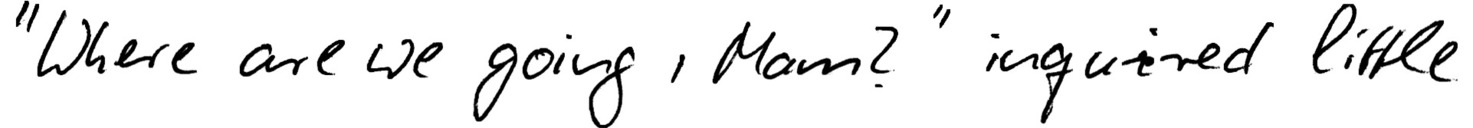

In [11]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [12]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

" Where are we going, Mam? " inquired little


In [13]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 30
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

cer_metric = load_metric("cer")

C:\Users\Legion\AppData\Local\Temp\ipykernel_27680\2475240303.py:12: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")


In [14]:
training_args = Seq2SeqTrainingArguments(
                                        output_dir="./checkpoints",
                                        predict_with_generate=True,
                                        evaluation_strategy="steps",
                                        per_device_train_batch_size=4,
                                        per_device_eval_batch_size=4,
                                        fp16=True, 
                                        output_dir="./",
                                        logging_steps=8,
                                        save_steps=1000,
                                        eval_steps=1000,
                                        )

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [15]:
trainer = Seq2SeqTrainer(
                        model=model,
                        tokenizer=processor.feature_extractor,
                        args=training_args,
                        compute_metrics=compute_metrics,
                        train_dataset=train_dataset,
                        eval_dataset=eval_dataset,
                        data_collator=default_data_collator,
                        )
trainer.train()

c:\Users\Legion\.conda\envs\tf210\lib\site-packages\transformers\models\trocr\processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
c:\Users\Legion\.conda\envs\tf210\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1749 [00:00<?, ?it/s]

{'loss': 9.0685, 'learning_rate': 4.988564894225272e-05, 'epoch': 0.01}
{'loss': 4.7487, 'learning_rate': 4.965694682675815e-05, 'epoch': 0.03}
{'loss': 3.877, 'learning_rate': 4.9428244711263584e-05, 'epoch': 0.04}
{'loss': 4.2486, 'learning_rate': 4.9199542595769016e-05, 'epoch': 0.05}
{'loss': 6.1357, 'learning_rate': 4.897084048027444e-05, 'epoch': 0.07}
{'loss': 6.1739, 'learning_rate': 4.8742138364779875e-05, 'epoch': 0.08}
{'loss': 5.3026, 'learning_rate': 4.851343624928531e-05, 'epoch': 0.1}
{'loss': 5.3167, 'learning_rate': 4.828473413379074e-05, 'epoch': 0.11}
{'loss': 5.2339, 'learning_rate': 4.805603201829617e-05, 'epoch': 0.12}
{'loss': 4.8746, 'learning_rate': 4.7827329902801605e-05, 'epoch': 0.14}
{'loss': 4.7721, 'learning_rate': 4.759862778730704e-05, 'epoch': 0.15}
{'loss': 4.5242, 'learning_rate': 4.736992567181246e-05, 'epoch': 0.16}
{'loss': 4.4476, 'learning_rate': 4.7141223556317895e-05, 'epoch': 0.18}
{'loss': 4.7815, 'learning_rate': 4.6912521440823335e-05, 'ep

In [ ]:
# save model
trainer.save_model("./checkpoints")

In [ ]:
# load model
model = VisionEncoderDecoderModel.from_pretrained("./checkpoints")
model.to("cuda")
